In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa

In [4]:
import keras.models
import keras.layers
from keras.models import Sequential
from keras.layers import Activation, Dense

In [5]:
import numpy as np

In [6]:
tf.config.experimental.list_physical_devices()

2022-05-12 19:43:14.316891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-05-12 19:43:14.363809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 19:43:14.364169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [7]:
dirsplit0 = "../20220408CAPSULE_DATA/splits/splitslowres/split_0/"

In [8]:
dirsplit1 = "../20220408CAPSULE_DATA/splits/splitslowres/split_1/"

In [9]:
#os.listdir(dirsplit0)

In [10]:
#os.listdir(dirsplit1)

In [8]:
'''
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def MCC(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())
'''

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
'''
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

'''

"\ntrain_datagen = ImageDataGenerator(\n    rescale=1./255,\n    rotation_range=40,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    zoom_range=0.2,\n    shear_range=0.2,\n    horizontal_flip=True,\n    fill_mode='nearest'\n    )\n\n"

In [10]:
TRAINING_DIR = dirsplit0
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    target_size=(168, 168))

Found 23061 images belonging to 11 classes.


In [11]:
# No need to augment validation set
validation_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
VALIDATION_DIR = dirsplit1
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              class_mode='categorical',
                                                              target_size=(168, 168))

Found 24100 images belonging to 11 classes.


## DenseNet169


In [29]:
#from tensorflow.keras.applications.resnet50 import ResNet50

In [13]:
from tensorflow.keras.applications.densenet import DenseNet169

In [14]:
pre_trained_model = DenseNet169(input_shape=(168,168,3),include_top =False, weights= 'imagenet')

2022-05-12 19:44:00.105084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 19:44:00.105362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 19:44:00.105568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 19:44:00.769929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 19:44:00.770158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [15]:
for layer in pre_trained_model.layers:  
    layer.trainable=False

In [16]:
last_layer = pre_trained_model.get_layer('conv5_block32_concat')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 1664)


In [17]:
x = keras.layers.Flatten()(last_output)

x = keras.layers.Dropout(0.4)(x)      

x = keras.layers.Dense(256, activation='relu')(x)

x = keras.layers.Dropout(0.2)(x)                  

x = keras.layers.Dense(11, activation='softmax')(x)           

model = keras.Model(pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=[tf.keras.metrics.Accuracy(), tfa.metrics.F1Score(num_classes=11, average="micro"), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.MatthewsCorrelationCoefficient(num_classes=11)])


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 168, 168, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 174, 174, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 84, 84, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 84, 84, 64)   256         ['conv1/conv[0][0]']         

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 42, 42, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 42, 42, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 42, 42, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 42, 42, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 21, 21, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 21, 21, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 21, 21, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 21, 21, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 21, 21, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 21, 21, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 21, 21, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 21, 21, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 21, 21, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 21, 21, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 21, 21, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 10, 10, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 10, 10, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 10, 10, 128)  40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 10, 10, 128)  512        ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 10, 10, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 10, 10, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 10, 10, 32)   36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 10, 10, 480)  0          ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 10, 10, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 10, 10, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 10, 10, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 10, 10, 608)  0          ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 10, 10, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 10, 10, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 10, 10, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 10, 10, 128)  0          ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 10, 10, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 10, 10, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 10, 10, 896)  0          ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 10, 10, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 10, 10, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 10, 10, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block25_1_conv (Conv2D)  (None, 10, 10, 128)  131072      ['conv4_block25_0_relu[0][0]']   
          

 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 10, 10, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 10, 10, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 10, 10, 128)  0          ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv5_block1_0_relu (Activatio  (None, 5, 5, 640)   0           ['conv5_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 5, 5, 128)    81920       ['conv5_block1_0_relu[0][0]']    
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 5, 5, 128)   512         ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block5_1_bn (BatchNormal  (None, 5, 5, 128)   512         ['conv5_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_1_relu (Activatio  (None, 5, 5, 128)   0           ['conv5_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block5_2_conv (Conv2D)   (None, 5, 5, 32)     36864       ['conv5_block5_1_relu[0][0]']    
                                                                                                  
 conv5_block5_concat (Concatena  (None, 5, 5, 800)   0           ['conv5_block4_concat[0][0]',    
 te)                                                              'conv5_block5_2_conv[0][0]']    
          

                                                                                                  
 conv5_block9_concat (Concatena  (None, 5, 5, 928)   0           ['conv5_block8_concat[0][0]',    
 te)                                                              'conv5_block9_2_conv[0][0]']    
                                                                                                  
 conv5_block10_0_bn (BatchNorma  (None, 5, 5, 928)   3712        ['conv5_block9_concat[0][0]']    
 lization)                                                                                        
                                                                                                  
 conv5_block10_0_relu (Activati  (None, 5, 5, 928)   0           ['conv5_block10_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block14_0_relu (Activati  (None, 5, 5, 1056)  0           ['conv5_block14_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block14_1_conv (Conv2D)  (None, 5, 5, 128)    135168      ['conv5_block14_0_relu[0][0]']   
                                                                                                  
 conv5_block14_1_bn (BatchNorma  (None, 5, 5, 128)   512         ['conv5_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block14_1_relu (Activati  (None, 5, 5, 128)   0           ['conv5_block14_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block18_1_relu (Activati  (None, 5, 5, 128)   0           ['conv5_block18_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block18_2_conv (Conv2D)  (None, 5, 5, 32)     36864       ['conv5_block18_1_relu[0][0]']   
                                                                                                  
 conv5_block18_concat (Concaten  (None, 5, 5, 1216)  0           ['conv5_block17_concat[0][0]',   
 ate)                                                             'conv5_block18_2_conv[0][0]']   
                                                                                                  
 conv5_block19_0_bn (BatchNorma  (None, 5, 5, 1216)  4864        ['conv5_block18_concat[0][0]']   
 lization)

 ate)                                                             'conv5_block22_2_conv[0][0]']   
                                                                                                  
 conv5_block23_0_bn (BatchNorma  (None, 5, 5, 1344)  5376        ['conv5_block22_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block23_0_relu (Activati  (None, 5, 5, 1344)  0           ['conv5_block23_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block23_1_conv (Conv2D)  (None, 5, 5, 128)    172032      ['conv5_block23_0_relu[0][0]']   
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block27_1_conv (Conv2D)  (None, 5, 5, 128)    188416      ['conv5_block27_0_relu[0][0]']   
                                                                                                  
 conv5_block27_1_bn (BatchNorma  (None, 5, 5, 128)   512         ['conv5_block27_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block27_1_relu (Activati  (None, 5, 5, 128)   0           ['conv5_block27_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block27_2_conv (Conv2D)  (None, 5, 5, 32)     36864       ['conv5_block27_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block31_2_conv (Conv2D)  (None, 5, 5, 32)     36864       ['conv5_block31_1_relu[0][0]']   
                                                                                                  
 conv5_block31_concat (Concaten  (None, 5, 5, 1632)  0           ['conv5_block30_concat[0][0]',   
 ate)                                                             'conv5_block31_2_conv[0][0]']   
                                                                                                  
 conv5_block32_0_bn (BatchNorma  (None, 5, 5, 1632)  6528        ['conv5_block31_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

In [19]:
history_resnet = model.fit(train_generator,
                              epochs=5,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/5


2022-05-12 19:44:31.769670: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


721/721 [==============================] - 246s 322ms/step - loss: 0.3909 - accuracy: 0.0000e+00 - f1_score: 0.8840 - precision: 0.9137 - recall: 0.8571 - MatthewsCorrelationCoefficient: 0.7578 - val_loss: 1.2686 - val_accuracy: 0.0000e+00 - val_f1_score: 0.7464 - val_precision: 0.7693 - val_recall: 0.7260 - val_MatthewsCorrelationCoefficient: 0.2583
Epoch 2/5
721/721 [==============================] - 224s 311ms/step - loss: 0.1600 - accuracy: 3.9421e-06 - f1_score: 0.9506 - precision: 0.9603 - recall: 0.9414 - MatthewsCorrelationCoefficient: 0.9008 - val_loss: 1.3958 - val_accuracy: 0.0000e+00 - val_f1_score: 0.7293 - val_precision: 0.7435 - val_recall: 0.7149 - val_MatthewsCorrelationCoefficient: 0.2936
Epoch 3/5
721/721 [==============================] - 223s 309ms/step - loss: 0.1102 - accuracy: 5.1247e-05 - f1_score: 0.9654 - precision: 0.9707 - recall: 0.9607 - MatthewsCorrelationCoefficient: 0.9311 - val_loss: 1.5371 - val_accuracy: 5.6582e-05 - val_f1_score: 0.7600 - val_preci

In [20]:
# evaluate the model
loss, accuracy, f1_score, precision, recall, MCC = model.evaluate(validation_generator, verbose=0)

In [21]:
print ("loss =",loss,"accuracy=",accuracy,"f1=",f1_score,"precision",precision,"recall",recall,"MCC",MCC)

loss = 1.582714557647705 accuracy= 0.0001697472616797313 f1= 0.7413693070411682 precision 0.7507006525993347 recall 0.7335684895515442 MCC 0.2858434319496155


In [24]:
ac = history_resnet.history['accuracy']
v_ac = history_resnet.history['val_accuracy']   
lo = history_resnet.history['loss']
v_lo = history_resnet.history['val_loss']
f = history_resnet.history['f1_score']
v_f = history_resnet.history['val_f1_score']
epochs = history_resnet.epoch

Text(0, 0.5, 'Accuracy')

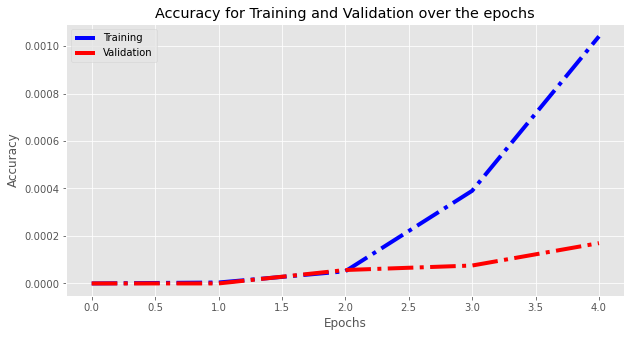

In [25]:
plt.figure(figsize=(10,5),frameon=False)
plt.plot(epochs,ac,c='b',ls='-.',lw='4',label='Training')
plt.plot(epochs,v_ac,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('Accuracy for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

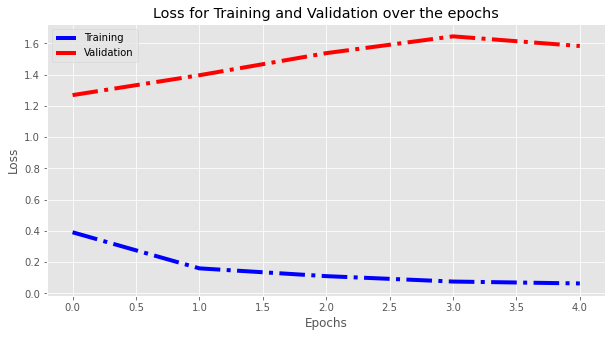

In [26]:
plt.figure(figsize=(10,5))
plt.plot(epochs,lo,c='b',ls='-.',lw='4',label='Training')
plt.plot(epochs,v_lo,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('Loss for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'f1')

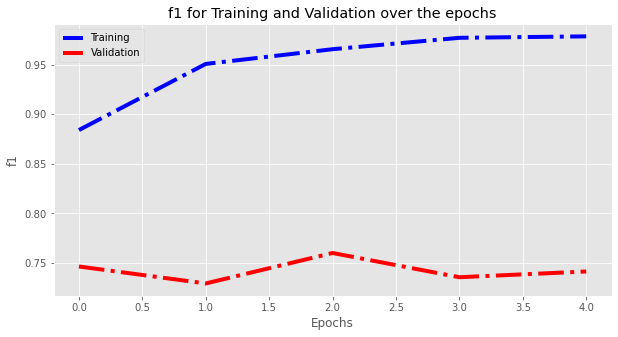

In [27]:
plt.figure(figsize=(10,5))
plt.plot(epochs,f,c='b',ls='-.',lw='4',label='Training')
plt.plot(epochs,v_f,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('f1 for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('f1')

In [1]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


NameError: name 'model' is not defined